## Evasion Attacks

In this lab, we will use the MNIST dataset to train an SVM model to classify handwritten digits.

First, get the data:

In [1]:
import secml

from secml.data.loader import CDataLoaderMNIST

# MNIST dataset will be downloaded and cached if needed
loader = CDataLoaderMNIST()

---

Now, let's train the model only for digits 5 and 9:

In [2]:
random_state = 999

n_tr = 100  # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500  # Number of test set samples

digits = (5, 9)

tr_val = loader.load('training', digits=digits, num_samples=n_tr + n_val)
ts = loader.load('testing', digits=digits, num_samples=n_ts)

# Split in training and validation set
tr = tr_val[:n_tr, :]
val = tr_val[n_tr:, :]

# Normalize the features in `[0, 1]`
tr.X /= 255
val.X /= 255
ts.X /= 255

from secml.ml.classifiers import CClassifierSVM
# train SVM in the dual space, on a linear kernel, as needed for poisoning
clf = CClassifierSVM(C=10, kernel='linear')

print("Training of classifier...")
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Metric to use for performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

Training of classifier...
Accuracy on test set: 93.60%


## The evasion attack
For the attack, we will modify pixels in the test data (perturbation) to make the model misclassify the images. We will generate an l2 pertubation with a max eps radius of 2.5 from the initial points.

We are using the PGD attack to generate the adversarial examples. The PGD attack is a multi-step variant of the FGSM attack. It generates adversarial examples by applying a small perturbation to each input feature. The perturbation is computed by taking a small step in the direction that maximizes the loss function. The PGD attack is more powerful than the FGSM attack because it performs multiple steps of optimization, which allows it to find more effective perturbations.


In [3]:
# For simplicity, let's attack a subset of the test set
attack_ds = ts[:25, :]

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 2.5  # Maximum perturbation
lb, ub = 0., 1.  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.5, 
    'eta_min': 2.0, 
    'eta_max': None,
    'max_iter': 100, 
    'eps': 1e-6
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    double_init_ds=tr,
                                    distance=noise_type, 
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(attack_ds.X, attack_ds.Y)
print("Attack complete!")

acc = metric.performance_score(
    y_true=attack_ds.Y, y_pred=clf.predict(attack_ds.X))
acc_attack = metric.performance_score(
    y_true=attack_ds.Y, y_pred=eva_y_pred)

print("Accuracy on reduced test set before attack: {:.2%}".format(acc))
print("Accuracy on reduced test set after attack: {:.2%}".format(acc_attack))

Attack started...
Attack complete!
Accuracy on reduced test set before attack: 100.00%
Accuracy on reduced test set after attack: 12.00%


We can observe how the classifier trained on the MNIST dataset has been 
 *successfully evaded* by the adversarial examples generated by our attack.
 
 ---
 
Let's now visualize few of the adversarial examples. The first row are the 
 original samples and the second row are the adversarial examples. Above each
 digit it is shown the true label and the predicted label in parenthesis. 

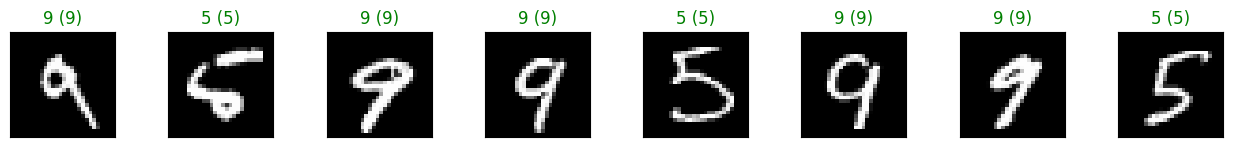

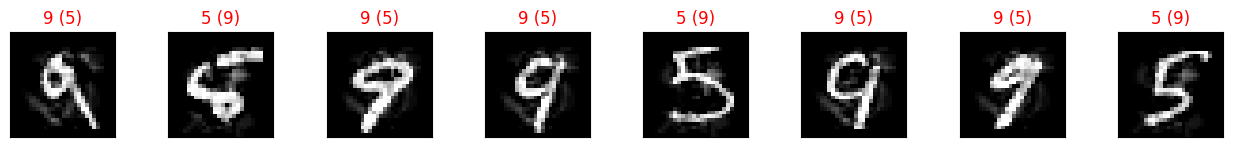

In [4]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

# Let's define a convenience function to easily plot the MNIST dataset
def show_digits(samples, preds, labels, digs, n_display=8):
    samples = samples.atleast_2d()
    n_display = min(n_display, samples.shape[0])
    fig = CFigure(width=n_display*2, height=3)
    for idx in range(n_display):
        fig.subplot(2, n_display, idx+1)
        fig.sp.xticks([])
        fig.sp.yticks([])
        fig.sp.imshow(samples[idx, :].reshape((28, 28)), cmap='gray')
        fig.sp.title("{} ({})".format(digits[labels[idx].item()], digs[preds[idx].item()]),
                     color=("green" if labels[idx].item()==preds[idx].item() else "red"))
    fig.show()

show_digits(attack_ds.X, clf.predict(attack_ds.X), attack_ds.Y, digits)
show_digits(eva_adv_ds.X, clf.predict(eva_adv_ds.X), eva_adv_ds.Y, digits)

---

Finally, let's show the model accuracy on different perturbation levels. Note - this will take a while to run.

Running security evaluation on subset...


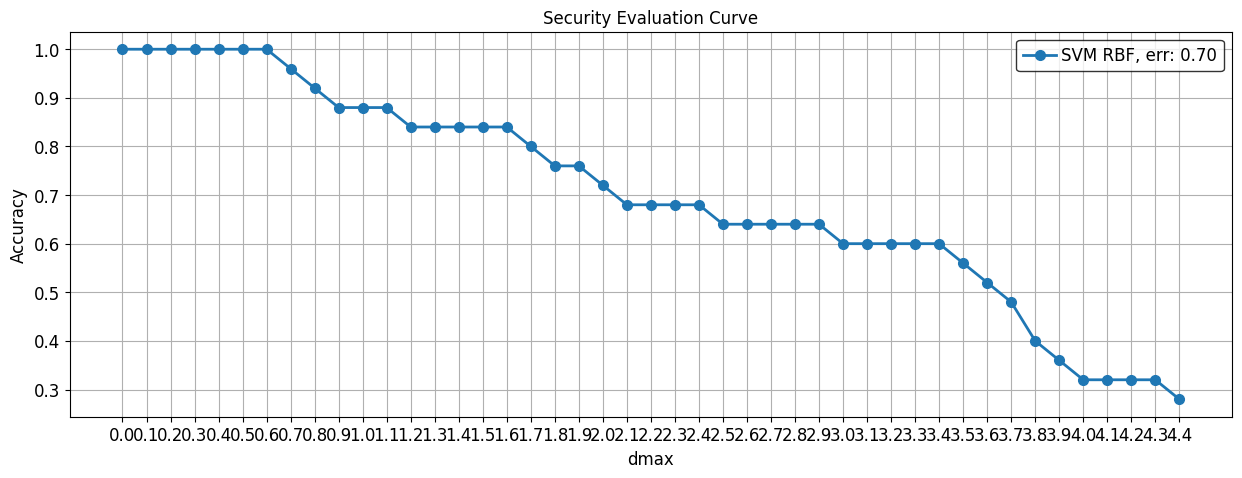

In [5]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=4.5)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation on subset...")
sec_eval.run_sec_eval(ts[:25, :])

from secml.figure import CFigure
fig = CFigure(height=5, width=15)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='SVM RBF', show_average=True)

As you can see in the chart, accuracy is not affected until the perturbation circle radius is greater than .05.  Then we see accuracy begin to drop off.  This is a good example of how adversarial attacks can be used to fool machine learning models.